
# Q-GAN

More specifically, we'll use Q-GAN to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
import numpy as np

In [2]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.8.0
Default GPU Device: /device:GPU:0


>**Note:** Make sure you have OpenAI Gym cloned. Then run this command 'pip install -e gym/[all]'.

In [3]:
import gym

# Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [4]:
env.reset()
rewards, states, actions, dones = [], [], [], []
for _ in range(10):
    #env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    states.append(state)
    rewards.append(reward)
    actions.append(action)
    dones.append(done)
    if done:
        states.append(state)
        rewards.append(reward)
        actions.append(action)
        dones.append(done)

To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [5]:
print(rewards[-20:])
print(np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print(np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print('actions:', np.max(np.array(actions)), np.min(np.array(actions)))
print('rewards min and max:', np.max(np.array(rewards)), np.min(np.array(rewards)))
print('state size:', np.array(states).shape, 
      'action size: {}'.format((np.max(np.array(actions)) - np.min(np.array(actions)))+1))

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
(10,) (10, 4) (10,) (10,)
float64 float64 int64 bool
actions: 1 0
rewards min and max: 1.0 1.0
state size: (10, 4) action size: 2


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

In [6]:
# Data of the model
def model_input(state_size):
    # Current and next states given
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    next_states = tf.placeholder(tf.float32, [None, state_size], name='next_states')
    
    # Previous and current actions given
    prev_actions = tf.placeholder(tf.int32, [None], name='prev_actions')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    
    # End of episodes/goal/task where nextQs = 0 and Qs=rs
    dones = tf.placeholder(tf.bool, [None], name='dones') # masked

    # Qs = qs+ (gamma * nextQs)
    nextQs = tf.placeholder(tf.float32, [None], name='nextQs') # masked
    nextQs_D = tf.placeholder(tf.float32, [None], name='nextQs_D') # masked
    nextnextQs_G = tf.placeholder(tf.float32, [None], name='nextQs_D') # masked
    
    # returning the given data to the model
    return prev_actions, states, actions, next_states, dones, nextQs, nextQs_D, nextnextQs_G

In [7]:
# Generator: Generating/predicting action and next states
def generator(prev_actions, states, action_size, state_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # Fusing states and actions
        x_fused = tf.concat(axis=1, values=[prev_actions, states])
        
        # First fully connected layer
        h1 = tf.layers.dense(inputs=x_fused, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=(action_size + state_size))
        actions_logits, next_states_logits = tf.split(axis=1, num_or_size_splits=[action_size, state_size], 
                                                      value=logits)
        #predictions = tf.nn.softmax(actions_logits)
        #predictions = tf.sigmoid(next_states_logits)

        # return actions and states logits
        return actions_logits, next_states_logits

In [8]:
def discriminator(prev_actions, states, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # Fusing states and actions
        x_fused = tf.concat(axis=1, values=[prev_actions, states])
        #print(x_fused.shape)
        
        # First fully connected layer
        h1 = tf.layers.dense(inputs=x_fused, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        #print(h1.shape)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        #print(h2.shape)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)
        #predictions = tf.nn.softmax(logits)

        # return reward logits/Qs
        return logits

In [9]:
# The model loss for predicted/generated actions
def model_loss(nextQs, prev_actions, states, actions, # model input data for targetQs
               state_size, action_size, hidden_size): # model init for Qs
    # Calculating Qs total rewards
    prev_actions_onehot = tf.one_hot(indices=prev_actions, depth=action_size)
    actions_logits, _ = generator(prev_actions=prev_actions_onehot, states=states, 
                                  hidden_size=hidden_size, state_size=state_size, action_size=action_size)
    
    # Masking actions_logits unmasked
    actions_mask = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    Qs_masked = tf.multiply(actions_logits, actions_mask)
    Qs = tf.reduce_max(Qs_masked, axis=1)
    
    # # Bellman equaion for calculating total rewards using current reward + total future rewards/nextQs
    # qs = tf.sigmoid(Qs) # qt
    # targetQs = qs + (gamma * nextQs)
    # # Calculating the loss: logits/predictions vs labels
    # q_loss = tf.reduce_mean(tf.square(Qs - targetQs))
    q_loss = tf.reduce_mean(tf.square(Qs - nextQs))

    return actions_logits, q_loss

In [10]:
# Outputing the unmasked nextQs for D to be used as the target/label
def model_output(actions, next_states,
                 action_size, hidden_size):
    # Discriminator for nextQs_D
    actions_onehot = tf.one_hot(indices=actions, depth=action_size)
    nextQs_D_unmasked = discriminator(prev_actions=actions_onehot, states=next_states, hidden_size=hidden_size)
    
    # Returning unmasked nextQs_D to masked using dones/ends of episodes
    return nextQs_D_unmasked

In [11]:
# The model loss for the NEW idea G & D
def model_loss2(nextQs_D, prev_actions, states, 
                action_size, hidden_size):
    # Calculating Qs total rewards using Discriminator
    prev_actions_onehot = tf.one_hot(indices=prev_actions, depth=action_size)
    Qs = discriminator(prev_actions=prev_actions_onehot, states=states, hidden_size=hidden_size, reuse=True)
        
    # # Bellman equaion: Qs = rt/qt + nextQs_G/D
    # qs = tf.sigmoid(Qs) # qt
    # targetQs_D = qs + (gamma * nextQs_D)
    # Calculating the loss: logits/predictions vs labels
    #d_loss = tf.reduce_mean(tf.square(Qs - targetQs_D))
    d_loss = tf.reduce_mean(tf.square(Qs - nextQs_D))
    
    # Returning the D loss
    return d_loss

In [12]:
# Calculating the loss of generator based on the generated/predicted states and actions
def model_output2(actions, next_states, 
                  state_size, action_size, hidden_size):
    # Generator for nextnextQs_G
    actions_onehot = tf.one_hot(indices=actions, depth=action_size)
    next_actions_logits, nextnext_states_logits = generator(prev_actions=actions_onehot, states=next_states,
                                                            hidden_size=hidden_size, state_size=state_size, 
                                                            action_size=action_size, reuse=True)
    
    # Discriminator for nextnextQs_G
    nextnextQs_G_unmasked = discriminator(prev_actions=next_actions_logits, states=nextnext_states_logits, 
                                          hidden_size=hidden_size, reuse=True)
        
    # Returning nextnextQs_G_unmasked
    return nextnextQs_G_unmasked

In [13]:
# Calculating the loss of generator based on the generated/predicted states and actions
def model_loss3(nextnextQs_G, prev_actions, states, dones, 
                state_size, action_size, hidden_size):
    # Generator for nextQs_G
    prev_actions_onehot = tf.one_hot(indices=prev_actions, depth=action_size)
    actions_logits, next_states_logits = generator(prev_actions=prev_actions_onehot, states=states,
                                                   hidden_size=hidden_size, state_size=state_size, 
                                                   action_size=action_size, reuse=True)
    
    # Discriminator for nextQs_G
    nextQs_G_unmasked = discriminator(prev_actions=actions_logits, states=next_states_logits, 
                                      hidden_size=hidden_size, reuse=True)
    
    # Masking the unmasked nextQs_G using dones/end of episodes/goal
    dones_mask = tf.reshape(tensor=(1 - tf.cast(dtype=nextQs_G_unmasked.dtype, x=dones)), shape=[-1, 1])
    nextQs_G_masked = tf.multiply(nextQs_G_unmasked, dones_mask)
    nextQs_G = tf.reduce_max(axis=1, input_tensor=nextQs_G_masked)

    # Below is the idea behind this loss
    # # Bellman equaion: Qs = rt/qt + nextQs_G/D
    # qs = tf.sigmoid(Qs) # qt
    # targetQs_G = qs + (gamma * nextQs_G)
    g_loss = tf.reduce_mean(tf.square(nextQs_G - nextnextQs_G))
    
    # Returning g_loss which should impact Generator
    return g_loss

In [15]:
def model_opt(q_loss, g_loss, d_loss, learning_rate):
    """
    Get optimization operations in order
    :param q_loss: Generator loss for action prediction
    :param g_loss: Generator loss for state prediction
    :param d_loss: Discriminator loss for reward prediction
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (qfunction training, generator training, discriminator training)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Used for BN (batchnorm params)
        g_opt = tf.train.AdamOptimizer(learning_rate).minimize((q_loss + g_loss), var_list=g_vars) # action prediction
        #d_opt = tf.train.AdamOptimizer(learning_rate).minimize((d_loss + g_loss), var_list=d_vars) # reward prediction
        d_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars) # reward prediction

    return g_opt, d_opt

In [16]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        ####################################### Model data inputs/outputs #######################################
        # Input of the Model: make the data available inside the framework
        self.prev_actions, self.states, self.actions, self.next_states, self.dones, self.nextQs, self.nextQs_D, self.nextnextQs_G = model_input(
            state_size=state_size)
        
        ######################################## Model losses #####################################################
        # Loss of the Model: action prediction/generation
        self.actions_logits, self.q_loss = model_loss(nextQs=self.nextQs, prev_actions=self.prev_actions, 
                                                      states=self.states, actions=self.actions,
                                                      state_size=state_size, action_size=action_size, 
                                                      hidden_size=hidden_size)

        # Loss of the model: states prediction/generation
        self.nextQs_D_unmasked = model_output(actions=self.actions, next_states=self.next_states,
                                              action_size=action_size, hidden_size=hidden_size)
        self.d_loss = model_loss2(nextQs_D=self.nextQs_D, prev_actions=self.prev_actions, states=self.states,
                                  action_size=action_size, hidden_size=hidden_size)
        
        # Loss of the model: states prediction/generation
        self.nextnextQs_G_unmasked = model_output2(actions=self.actions, next_states=self.next_states,
                                                   state_size=state_size, action_size=action_size, 
                                                   hidden_size=hidden_size)
        self.g_loss = model_loss3(nextnextQs_G=self.nextnextQs_G, dones=self.dones,
                                  prev_actions=self.prev_actions, states=self.states,
                                  state_size=state_size, action_size=action_size, hidden_size=hidden_size)
        
        ######################################## Model updates #####################################################
        # Update the model: backward pass and backprop
        self.g_opt, self.d_opt = model_opt(q_loss=self.q_loss,
                                           g_loss=self.g_loss, 
                                           d_loss=self.d_loss, learning_rate=learning_rate)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maxmium capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [17]:
from collections import deque

class Memory():    
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
    
    def add(self, experience):
        self.buffer.append(experience)
            
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]

## Exploration - Exploitation

To learn about the environment and rules of the game, the agent needs to explore by taking random actions. We'll do this by choosing a random action with some probability $\epsilon$ (epsilon).  That is, with some probability $\epsilon$ the agent will make a random action and with probability $1 - \epsilon$, the agent will choose an action from $Q(s,a)$. This is called an **$\epsilon$-greedy policy**.


At first, the agent needs to do a lot of exploring. Later when it has learned more, the agent can favor choosing actions based on what it has learned. This is called _exploitation_. We'll set it up so the agent is more likely to explore early in training, then more likely to exploit later in training.

## Q-Learning training algorithm

Putting all this together, we can list out the algorithm we'll use to train the network. We'll train the network in _episodes_. One *episode* is one simulation of the game. For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode = 1, $M$ **do**
  * **For** $t$, $T$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [18]:
print('state size:', np.array(states).shape[1], 
      'action size: {}'.format((np.max(np.array(actions)) - np.min(np.array(actions)))+1))

state size: 4 action size: 2


In [19]:
# Training params
train_episodes = 2000          # max number of episodes to learn from
max_steps = 2000000000000000   # max steps in an episode

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4                 # number of units for the input state/observation -- simulation
hidden_size = 64               # number of units in each Q-network hidden layer -- simulation
action_size = 2                # number of units for the output actions -- simulation

# Memory parameters
memory_size = 100000           # memory capacity
batch_size = 200               # experience mini-batch size
learning_rate = 0.001          # learning rate for adam

In [20]:
# Reset/init the graph/session
tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

# Init the memory
memory = Memory(max_size=memory_size)

## Populate the memory

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [21]:
# Initialize the simulation
env.reset()

# Take one random step to get the pole and cart moving
prev_action = env.action_space.sample() # At-1
state, _, done, _ = env.step(prev_action) # St, Rt/Et (Epiosde)

# Make a bunch of random actions and store the experiences
for _ in range(batch_size):
    # Make a random action
    action = env.action_space.sample()# At
    next_state, _, done, _ = env.step(action) #St+1

    # End of the episodes which defines the goal of the episode/mission
    if done is True:
        # Add experience to memory
        memory.add((prev_action, state, action, next_state, done))
        
        # Start new episode
        env.reset()
        
        # Take one random step to get the pole and cart moving
        prev_action = env.action_space.sample()
        state, _, done, _ = env.step(prev_action)
    else:
        # Add experience to memory
        memory.add((prev_action, state, action, next_state, done))
        
        # Prepare for the next round
        prev_action = action
        state = next_state

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [22]:
# Now train with experiences
saver = tf.train.Saver()

# Total rewards and losses list for plotting
rewards_list = []
q_loss_list = []
g_loss_list = []
d_loss_list = []

# TF session for training
with tf.Session() as sess:
    
    # Initialize variables
    sess.run(tf.global_variables_initializer())

    # Restore/load the trained model 
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Training episodes/epochs
    step = 0
    for ep in range(train_episodes):
        
        # Env/agent steps/batches/minibatches
        total_reward = 0
        q_loss = 0
        g_loss = 0
        d_loss = 0
        t = 0
        while t < max_steps:
            step += 1
            
            # Explore or Exploit
            explore_p = explore_stop + (explore_start - explore_stop)*np.exp(-decay_rate*step) 
            if explore_p > np.random.rand():
                # Make a random action
                action = env.action_space.sample()
            else:
                # Get action from model
                feed_dict = {model.prev_actions: np.array([prev_action]), 
                             model.states: state.reshape((1, *state.shape))}
                actions_logits = sess.run(model.actions_logits, feed_dict)
                action = np.argmax(actions_logits) # arg with max value/Q is the class of action
            
            # Take action, get new state and reward
            next_state, _, done, _ = env.step(action)
    
            # Cumulative reward
            #total_reward += reward
            total_reward += 1 # done=False
            
            # Episode/epoch training is done/failed!
            if done is True:
                # the episode ends so no next state
                #next_state = np.zeros(state.shape)
                t = max_steps
                
                print('-------------------------------------------------------------------------------')
                print('Episode: {}'.format(ep),
                      'Total reward: {}'.format(total_reward),
                      'Training q_loss: {:.4f}'.format(q_loss),
                      'Training g_loss: {:.4f}'.format(g_loss),
                      'Training d_loss: {:.4f}'.format(d_loss),
                      'Explore P: {:.4f}'.format(explore_p))
                print('-------------------------------------------------------------------------------')
                
                # total rewards and losses for plotting
                rewards_list.append((ep, total_reward))
                q_loss_list.append((ep, q_loss))
                g_loss_list.append((ep, g_loss))
                d_loss_list.append((ep, d_loss))
                
                # Add experience to memory
                memory.add((prev_action, state, action, next_state, done))
                
                # Start new episode
                env.reset()
                
                # Take one random step to get the pole and cart moving
                prev_action = env.action_space.sample()
                state, _, done, _ = env.step(prev_action)

            else:
                # Add experience to memory
                memory.add((prev_action, state, action, next_state, done))
                
                # One step forward: At-1=At and St=St+1
                prev_action = action
                state = next_state
                t += 1
            
            # Sample mini-batch from memory
            batch = memory.sample(batch_size)
            prev_actions = np.array([each[0] for each in batch])
            states = np.array([each[1] for each in batch])
            actions = np.array([each[2] for each in batch])
            next_states = np.array([each[3] for each in batch])
            dones = np.array([each[4] for each in batch])
            
            # Calculating nextQs and setting them to 0 for states where episode ends/fails
            feed_dict={model.prev_actions: actions, 
                       model.states: next_states}
            next_actions_logits = sess.run(model.actions_logits, feed_dict)
            nextQs_unmasked = next_actions_logits # for naming
            
            # Calculating nextQs for Discriminator using D(At, St+1)= Qt+1/nextQs_D/nextQs
            # Calculating nextQs for Discriminator using D(~At, ~St+1)= ~Qt+1/nextQs_G/nextQs2
            feed_dict={model.prev_actions: prev_actions, model.states: states,
                       model.actions: actions, model.next_states: next_states}
            nextQs_D_unmasked, nextnextQs_G_unmasked = sess.run([model.nextQs_D_unmasked,
                                                                 model.nextnextQs_G_unmasked], feed_dict)
            
            # Masking for the end of episodes/ goals
            #dones_mask = (1 - dones.astype(nextQs_D_unmasked[0].dtype)).reshape(-1, 1)
            dones_mask = (1 - dones.astype(nextQs_unmasked.dtype)).reshape(-1, 1) 
            nextQs_masked = np.multiply(nextQs_unmasked, dones_mask)
            nextQs_D_masked = np.multiply(nextQs_D_unmasked[0], dones_mask)
            nextnextQs_G_masked = np.multiply(nextnextQs_G_unmasked[0], dones_mask)
            nextQs = np.max(nextQs_masked, axis=1)
            nextQs_D = np.max(nextQs_D_masked, axis=1)
            nextnextQs_G = np.max(nextnextQs_G_masked, axis=1)
            
            # Calculating nextQs for Discriminator using D(At-1, St)= Qt: NOT this one
            # NextQs/Qt+1 are given both:
            feed_dict = {model.prev_actions: prev_actions, 
                         model.states: states, 
                         model.actions: actions, 
                         model.next_states: next_states, 
                         model.dones: dones,
                         model.nextQs: nextQs,
                         model.nextQs_D: nextQs_D,
                         model.nextnextQs_G: nextnextQs_G}
            q_loss, g_loss, d_loss, _, _ = sess.run([model.q_loss,
                                                     model.g_loss,
                                                     model.d_loss,
                                                     model.g_opt,
                                                     model.d_opt], feed_dict)
            # q_loss, g_loss, _ = sess.run([model.q_loss,
            #                               model.g_loss,
            #                               model.g_opt], feed_dict)
            # d_loss, _ = sess.run([model.d_loss,
            #                       model.d_opt], feed_dict)
                        
    # Save the trained model
    saver.save(sess, 'checkpoints/model.ckpt')

-------------------------------------------------------------------------------
Episode: 0 Total reward: 2 Training q_loss: 0.0049 Training g_loss: 0.0019 Training d_loss: 0.0403 Explore P: 0.9998
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1 Total reward: 23 Training q_loss: 0.0391 Training g_loss: 0.0001 Training d_loss: 0.0023 Explore P: 0.9975
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2 Total reward: 13 Training q_loss: 0.0366 Training g_loss: 0.0000 Training d_loss: 0.0013 Explore P: 0.9962
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3 Total reward: 21 Training q_loss: 0.0329 Training g_loss: 0.0000 Training d_

-------------------------------------------------------------------------------
Episode: 31 Total reward: 13 Training q_loss: 0.0363 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.9383
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 32 Total reward: 15 Training q_loss: 0.0380 Training g_loss: 0.0000 Training d_loss: 0.0001 Explore P: 0.9370
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 33 Total reward: 12 Training q_loss: 0.0346 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.9358
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 34 Total reward: 18 Training q_loss: 0.0351 Training g_loss: 0.0000 Traini

-------------------------------------------------------------------------------
Episode: 61 Total reward: 29 Training q_loss: 0.4719 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.8813
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 62 Total reward: 18 Training q_loss: 0.6067 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.8797
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 63 Total reward: 30 Training q_loss: 0.6258 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.8771
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 64 Total reward: 48 Training q_loss: 0.2848 Training g_loss: 0.0000 Traini

-------------------------------------------------------------------------------
Episode: 92 Total reward: 11 Training q_loss: 0.0215 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.8282
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 93 Total reward: 13 Training q_loss: 0.0182 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.8271
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 94 Total reward: 24 Training q_loss: 0.0187 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.8252
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 95 Total reward: 37 Training q_loss: 0.0164 Training g_loss: 0.0000 Traini

-------------------------------------------------------------------------------
Episode: 122 Total reward: 11 Training q_loss: 0.0064 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.7817
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 123 Total reward: 26 Training q_loss: 0.0066 Training g_loss: 0.0000 Training d_loss: 0.0003 Explore P: 0.7797
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 124 Total reward: 11 Training q_loss: 0.0062 Training g_loss: 0.0000 Training d_loss: 0.0001 Explore P: 0.7789
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 125 Total reward: 29 Training q_loss: 0.0115 Training g_loss: 0.0000 Tr

-------------------------------------------------------------------------------
Episode: 153 Total reward: 35 Training q_loss: 0.0050 Training g_loss: 0.0000 Training d_loss: 0.0001 Explore P: 0.7410
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 154 Total reward: 12 Training q_loss: 0.0043 Training g_loss: 0.0000 Training d_loss: 0.0001 Explore P: 0.7401
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 155 Total reward: 23 Training q_loss: 0.0032 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.7384
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 156 Total reward: 17 Training q_loss: 0.0033 Training g_loss: 0.0000 Tr

-------------------------------------------------------------------------------
Episode: 183 Total reward: 22 Training q_loss: 0.0024 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.6984
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 184 Total reward: 35 Training q_loss: 0.0024 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.6960
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 185 Total reward: 25 Training q_loss: 0.0021 Training g_loss: 0.0000 Training d_loss: 0.0004 Explore P: 0.6943
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 186 Total reward: 14 Training q_loss: 0.0021 Training g_loss: 0.0000 Tr

-------------------------------------------------------------------------------
Episode: 214 Total reward: 39 Training q_loss: 0.0089 Training g_loss: 0.0000 Training d_loss: 0.0002 Explore P: 0.6594
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 215 Total reward: 14 Training q_loss: 0.0066 Training g_loss: 0.0000 Training d_loss: 0.0001 Explore P: 0.6585
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 216 Total reward: 14 Training q_loss: 0.0050 Training g_loss: 0.0000 Training d_loss: 0.0002 Explore P: 0.6576
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 217 Total reward: 18 Training q_loss: 0.0030 Training g_loss: 0.0000 Tr

-------------------------------------------------------------------------------
Episode: 244 Total reward: 29 Training q_loss: 0.0082 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.6269
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 245 Total reward: 53 Training q_loss: 0.0069 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.6236
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 246 Total reward: 24 Training q_loss: 0.0075 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.6222
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 247 Total reward: 44 Training q_loss: 0.0080 Training g_loss: 0.0000 Tr

-------------------------------------------------------------------------------
Episode: 275 Total reward: 12 Training q_loss: 0.0084 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.5946
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 276 Total reward: 9 Training q_loss: 0.0086 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.5941
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 277 Total reward: 8 Training q_loss: 0.0076 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.5937
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 278 Total reward: 20 Training q_loss: 0.0085 Training g_loss: 0.0000 Trai

-------------------------------------------------------------------------------
Episode: 305 Total reward: 12 Training q_loss: 0.0074 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.5695
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 306 Total reward: 10 Training q_loss: 0.0073 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.5689
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 307 Total reward: 9 Training q_loss: 0.0063 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.5684
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 308 Total reward: 9 Training q_loss: 0.0050 Training g_loss: 0.0000 Trai

-------------------------------------------------------------------------------
Episode: 335 Total reward: 35 Training q_loss: 0.0105 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.5391
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 336 Total reward: 21 Training q_loss: 0.0108 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.5380
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 337 Total reward: 17 Training q_loss: 0.0121 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.5371
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 338 Total reward: 14 Training q_loss: 0.0113 Training g_loss: 0.0000 Tr

-------------------------------------------------------------------------------
Episode: 365 Total reward: 24 Training q_loss: 0.0143 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.5153
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 366 Total reward: 15 Training q_loss: 0.0129 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.5145
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 367 Total reward: 15 Training q_loss: 0.0130 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.5138
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 368 Total reward: 9 Training q_loss: 0.0130 Training g_loss: 0.0000 Tra

-------------------------------------------------------------------------------
Episode: 395 Total reward: 16 Training q_loss: 0.0146 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.4954
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 396 Total reward: 12 Training q_loss: 0.0142 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.4948
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 397 Total reward: 11 Training q_loss: 0.0134 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.4943
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 398 Total reward: 14 Training q_loss: 0.0146 Training g_loss: 0.0000 Tr

-------------------------------------------------------------------------------
Episode: 425 Total reward: 16 Training q_loss: 0.0141 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.4751
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 426 Total reward: 9 Training q_loss: 0.0141 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.4747
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 427 Total reward: 27 Training q_loss: 0.0138 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.4735
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 428 Total reward: 9 Training q_loss: 0.0141 Training g_loss: 0.0000 Trai

-------------------------------------------------------------------------------
Episode: 456 Total reward: 14 Training q_loss: 0.0165 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.4570
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 457 Total reward: 12 Training q_loss: 0.0167 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.4564
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 458 Total reward: 13 Training q_loss: 0.0162 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.4559
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 459 Total reward: 12 Training q_loss: 0.0163 Training g_loss: 0.0000 Tr

-------------------------------------------------------------------------------
Episode: 486 Total reward: 12 Training q_loss: 0.0155 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.4402
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 487 Total reward: 12 Training q_loss: 0.0151 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.4397
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 488 Total reward: 13 Training q_loss: 0.0153 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.4391
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 489 Total reward: 13 Training q_loss: 0.0147 Training g_loss: 0.0000 Tr

-------------------------------------------------------------------------------
Episode: 517 Total reward: 9 Training q_loss: 0.0170 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.4227
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 518 Total reward: 8 Training q_loss: 0.0168 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.4223
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 519 Total reward: 10 Training q_loss: 0.0171 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.4219
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 520 Total reward: 9 Training q_loss: 0.0182 Training g_loss: 0.0000 Train

-------------------------------------------------------------------------------
Episode: 548 Total reward: 8 Training q_loss: 0.0163 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.4087
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 549 Total reward: 9 Training q_loss: 0.0166 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.4083
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 550 Total reward: 21 Training q_loss: 0.0175 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.4075
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 551 Total reward: 12 Training q_loss: 0.0219 Training g_loss: 0.0000 Trai

-------------------------------------------------------------------------------
Episode: 578 Total reward: 22 Training q_loss: 0.1491 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.3911
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 579 Total reward: 12 Training q_loss: 0.1579 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.3907
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 580 Total reward: 15 Training q_loss: 0.1524 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.3901
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 581 Total reward: 29 Training q_loss: 0.1543 Training g_loss: 0.0000 Tr

-------------------------------------------------------------------------------
Episode: 608 Total reward: 40 Training q_loss: 0.0994 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.3663
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 609 Total reward: 25 Training q_loss: 0.0944 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.3654
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 610 Total reward: 28 Training q_loss: 0.0974 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.3644
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 611 Total reward: 23 Training q_loss: 0.0971 Training g_loss: 0.0000 Tr

-------------------------------------------------------------------------------
Episode: 639 Total reward: 8 Training q_loss: 0.0920 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.3401
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 640 Total reward: 14 Training q_loss: 0.0843 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.3397
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 641 Total reward: 15 Training q_loss: 0.0817 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.3392
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 642 Total reward: 13 Training q_loss: 0.0848 Training g_loss: 0.0000 Tra

-------------------------------------------------------------------------------
Episode: 669 Total reward: 26 Training q_loss: 0.1372 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.3200
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 670 Total reward: 32 Training q_loss: 0.1350 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.3191
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 671 Total reward: 44 Training q_loss: 0.1308 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.3177
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 672 Total reward: 27 Training q_loss: 0.1351 Training g_loss: 0.0000 Tr

-------------------------------------------------------------------------------
Episode: 699 Total reward: 8 Training q_loss: 0.1823 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.2994
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 700 Total reward: 12 Training q_loss: 0.1726 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.2991
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 701 Total reward: 14 Training q_loss: 0.1642 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.2986
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 702 Total reward: 8 Training q_loss: 0.1662 Training g_loss: 0.0000 Trai

-------------------------------------------------------------------------------
Episode: 729 Total reward: 9 Training q_loss: 0.1487 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.2873
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 730 Total reward: 9 Training q_loss: 0.1453 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.2871
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 731 Total reward: 10 Training q_loss: 0.1470 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.2868
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 732 Total reward: 14 Training q_loss: 0.1465 Training g_loss: 0.0000 Trai

-------------------------------------------------------------------------------
Episode: 759 Total reward: 14 Training q_loss: 0.2319 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.2779
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 760 Total reward: 8 Training q_loss: 0.2123 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.2777
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 761 Total reward: 12 Training q_loss: 0.2280 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.2773
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 762 Total reward: 10 Training q_loss: 0.2152 Training g_loss: 0.0000 Tra

-------------------------------------------------------------------------------
Episode: 789 Total reward: 12 Training q_loss: 0.2939 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.2690
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 790 Total reward: 8 Training q_loss: 0.2928 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.2688
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 791 Total reward: 15 Training q_loss: 0.2893 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.2684
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 792 Total reward: 10 Training q_loss: 0.3068 Training g_loss: 0.0000 Tra

-------------------------------------------------------------------------------
Episode: 820 Total reward: 7 Training q_loss: 0.3225 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.2601
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 821 Total reward: 12 Training q_loss: 0.3440 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.2598
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 822 Total reward: 8 Training q_loss: 0.3412 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.2596
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 823 Total reward: 12 Training q_loss: 0.3447 Training g_loss: 0.0000 Trai

-------------------------------------------------------------------------------
Episode: 850 Total reward: 13 Training q_loss: 0.2872 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.2521
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 851 Total reward: 10 Training q_loss: 0.2741 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.2518
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 852 Total reward: 11 Training q_loss: 0.2694 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.2516
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 853 Total reward: 14 Training q_loss: 0.2605 Training g_loss: 0.0000 Tr

-------------------------------------------------------------------------------
Episode: 881 Total reward: 10 Training q_loss: 0.1979 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.2435
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 882 Total reward: 12 Training q_loss: 0.1680 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.2432
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 883 Total reward: 15 Training q_loss: 0.1577 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.2429
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 884 Total reward: 16 Training q_loss: 0.1508 Training g_loss: 0.0000 Tr

-------------------------------------------------------------------------------
Episode: 912 Total reward: 10 Training q_loss: 0.1823 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.2355
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 913 Total reward: 11 Training q_loss: 0.1867 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.2352
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 914 Total reward: 7 Training q_loss: 0.1690 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.2351
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 915 Total reward: 10 Training q_loss: 0.1791 Training g_loss: 0.0000 Tra

-------------------------------------------------------------------------------
Episode: 942 Total reward: 11 Training q_loss: 0.0679 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.2282
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 943 Total reward: 10 Training q_loss: 0.0642 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.2280
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 944 Total reward: 12 Training q_loss: 0.0664 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.2277
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 945 Total reward: 13 Training q_loss: 0.0644 Training g_loss: 0.0000 Tr

-------------------------------------------------------------------------------
Episode: 972 Total reward: 15 Training q_loss: 0.2145 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.2205
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 973 Total reward: 11 Training q_loss: 0.2458 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.2203
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 974 Total reward: 8 Training q_loss: 0.2624 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.2201
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 975 Total reward: 11 Training q_loss: 0.2979 Training g_loss: 0.0000 Tra

-------------------------------------------------------------------------------
Episode: 1002 Total reward: 8 Training q_loss: 1.9486 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.2137
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1003 Total reward: 9 Training q_loss: 1.8263 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.2135
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1004 Total reward: 8 Training q_loss: 1.9906 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.2134
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1005 Total reward: 8 Training q_loss: 2.0127 Training g_loss: 0.0000 Tr

-------------------------------------------------------------------------------
Episode: 1032 Total reward: 11 Training q_loss: 1.5823 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.2077
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1033 Total reward: 12 Training q_loss: 1.6183 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.2075
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1034 Total reward: 18 Training q_loss: 1.5689 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.2071
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1035 Total reward: 8 Training q_loss: 1.6328 Training g_loss: 0.0000

-------------------------------------------------------------------------------
Episode: 1063 Total reward: 9 Training q_loss: 1.4514 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.2013
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1064 Total reward: 8 Training q_loss: 1.4378 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.2011
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1065 Total reward: 9 Training q_loss: 1.3926 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.2009
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1066 Total reward: 7 Training q_loss: 1.3633 Training g_loss: 0.0000 Tr

-------------------------------------------------------------------------------
Episode: 1093 Total reward: 11 Training q_loss: 1.3389 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.1952
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1094 Total reward: 8 Training q_loss: 1.4124 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.1950
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1095 Total reward: 10 Training q_loss: 1.3190 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.1948
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1096 Total reward: 12 Training q_loss: 1.3249 Training g_loss: 0.0000

-------------------------------------------------------------------------------
Episode: 1123 Total reward: 13 Training q_loss: 1.2728 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.1893
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1124 Total reward: 17 Training q_loss: 1.1347 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.1890
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1125 Total reward: 9 Training q_loss: 1.1522 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.1889
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1126 Total reward: 12 Training q_loss: 1.1894 Training g_loss: 0.0000

-------------------------------------------------------------------------------
Episode: 1154 Total reward: 10 Training q_loss: 1.0160 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.1833
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1155 Total reward: 9 Training q_loss: 1.0336 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.1831
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1156 Total reward: 8 Training q_loss: 1.0439 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.1830
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1157 Total reward: 10 Training q_loss: 1.0367 Training g_loss: 0.0000 

-------------------------------------------------------------------------------
Episode: 1184 Total reward: 10 Training q_loss: 0.9861 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.1783
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1185 Total reward: 9 Training q_loss: 1.0403 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.1781
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1186 Total reward: 14 Training q_loss: 0.9618 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.1779
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1187 Total reward: 8 Training q_loss: 0.9806 Training g_loss: 0.0000 

-------------------------------------------------------------------------------
Episode: 1215 Total reward: 8 Training q_loss: 1.0233 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.1730
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1216 Total reward: 13 Training q_loss: 0.9749 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.1728
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1217 Total reward: 7 Training q_loss: 0.9885 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.1727
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1218 Total reward: 11 Training q_loss: 1.0326 Training g_loss: 0.0000 

-------------------------------------------------------------------------------
Episode: 1245 Total reward: 9 Training q_loss: 0.6845 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.1680
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1246 Total reward: 8 Training q_loss: 0.6563 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.1679
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1247 Total reward: 9 Training q_loss: 0.6458 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.1677
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1248 Total reward: 11 Training q_loss: 0.6156 Training g_loss: 0.0000 T

-------------------------------------------------------------------------------
Episode: 1275 Total reward: 9 Training q_loss: 0.5932 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.1633
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1276 Total reward: 8 Training q_loss: 0.6016 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.1632
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1277 Total reward: 10 Training q_loss: 0.6378 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.1630
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1278 Total reward: 10 Training q_loss: 0.6303 Training g_loss: 0.0000 

-------------------------------------------------------------------------------
Episode: 1305 Total reward: 12 Training q_loss: 0.5901 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.1585
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1306 Total reward: 11 Training q_loss: 0.5860 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.1584
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1307 Total reward: 7 Training q_loss: 0.5729 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.1583
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1308 Total reward: 10 Training q_loss: 0.5641 Training g_loss: 0.0000

-------------------------------------------------------------------------------
Episode: 1335 Total reward: 8 Training q_loss: 0.6395 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.1541
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1336 Total reward: 11 Training q_loss: 0.6127 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.1539
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1337 Total reward: 12 Training q_loss: 0.5893 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.1538
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1338 Total reward: 12 Training q_loss: 0.5927 Training g_loss: 0.0000

-------------------------------------------------------------------------------
Episode: 1365 Total reward: 13 Training q_loss: 0.5883 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.1498
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1366 Total reward: 9 Training q_loss: 0.5928 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.1497
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1367 Total reward: 11 Training q_loss: 0.5981 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.1495
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1368 Total reward: 12 Training q_loss: 0.5982 Training g_loss: 0.0000

-------------------------------------------------------------------------------
Episode: 1395 Total reward: 11 Training q_loss: 0.6195 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.1455
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1396 Total reward: 11 Training q_loss: 0.5814 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.1453
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1397 Total reward: 13 Training q_loss: 0.5808 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.1452
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1398 Total reward: 10 Training q_loss: 0.5913 Training g_loss: 0.000

-------------------------------------------------------------------------------
Episode: 1426 Total reward: 12 Training q_loss: 0.5008 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.1411
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1427 Total reward: 11 Training q_loss: 0.5021 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.1410
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1428 Total reward: 7 Training q_loss: 0.4827 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.1409
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1429 Total reward: 8 Training q_loss: 0.4705 Training g_loss: 0.0000 

-------------------------------------------------------------------------------
Episode: 1456 Total reward: 11 Training q_loss: 0.4204 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.1371
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1457 Total reward: 11 Training q_loss: 0.4170 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.1370
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1458 Total reward: 12 Training q_loss: 0.3843 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.1368
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1459 Total reward: 9 Training q_loss: 0.3882 Training g_loss: 0.0000

-------------------------------------------------------------------------------
Episode: 1486 Total reward: 10 Training q_loss: 0.2662 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.1333
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1487 Total reward: 11 Training q_loss: 0.2494 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.1332
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1488 Total reward: 9 Training q_loss: 0.2335 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.1330
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1489 Total reward: 11 Training q_loss: 0.2147 Training g_loss: 0.0000

-------------------------------------------------------------------------------
Episode: 1517 Total reward: 8 Training q_loss: 0.2009 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.1294
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1518 Total reward: 9 Training q_loss: 0.1878 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.1293
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1519 Total reward: 10 Training q_loss: 0.1966 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.1292
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1520 Total reward: 11 Training q_loss: 0.1778 Training g_loss: 0.0000 

-------------------------------------------------------------------------------
Episode: 1548 Total reward: 12 Training q_loss: 0.0669 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.1255
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1549 Total reward: 10 Training q_loss: 0.0629 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.1254
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1550 Total reward: 16 Training q_loss: 0.0614 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.1252
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1551 Total reward: 9 Training q_loss: 0.0592 Training g_loss: 0.0000

-------------------------------------------------------------------------------
Episode: 1578 Total reward: 11 Training q_loss: 0.0293 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.1221
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1579 Total reward: 11 Training q_loss: 0.0287 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.1220
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1580 Total reward: 9 Training q_loss: 0.0286 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.1219
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1581 Total reward: 12 Training q_loss: 0.0286 Training g_loss: 0.0000

-------------------------------------------------------------------------------
Episode: 1608 Total reward: 8 Training q_loss: 0.0243 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.1188
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1609 Total reward: 9 Training q_loss: 0.0249 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.1187
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1610 Total reward: 10 Training q_loss: 0.0235 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.1186
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1611 Total reward: 10 Training q_loss: 0.0204 Training g_loss: 0.0000 

-------------------------------------------------------------------------------
Episode: 1638 Total reward: 10 Training q_loss: 0.0587 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.1156
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1639 Total reward: 7 Training q_loss: 0.0607 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.1155
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1640 Total reward: 10 Training q_loss: 0.0625 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.1154
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1641 Total reward: 10 Training q_loss: 0.0656 Training g_loss: 0.0000

-------------------------------------------------------------------------------
Episode: 1668 Total reward: 9 Training q_loss: 0.0850 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.1126
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1669 Total reward: 11 Training q_loss: 0.0993 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.1125
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1670 Total reward: 9 Training q_loss: 0.1071 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.1124
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1671 Total reward: 9 Training q_loss: 0.1082 Training g_loss: 0.0000 T

-------------------------------------------------------------------------------
Episode: 1698 Total reward: 10 Training q_loss: 0.1243 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.1095
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1699 Total reward: 8 Training q_loss: 0.1270 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.1094
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1700 Total reward: 8 Training q_loss: 0.1291 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.1094
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1701 Total reward: 10 Training q_loss: 0.1307 Training g_loss: 0.0000 

-------------------------------------------------------------------------------
Episode: 1728 Total reward: 10 Training q_loss: 0.1355 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.1066
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1729 Total reward: 11 Training q_loss: 0.1273 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.1065
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1730 Total reward: 11 Training q_loss: 0.1254 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.1064
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1731 Total reward: 11 Training q_loss: 0.1260 Training g_loss: 0.000

-------------------------------------------------------------------------------
Episode: 1758 Total reward: 14 Training q_loss: 0.1310 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.1037
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1759 Total reward: 10 Training q_loss: 0.1313 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.1037
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1760 Total reward: 9 Training q_loss: 0.1297 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.1036
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1761 Total reward: 7 Training q_loss: 0.1341 Training g_loss: 0.0000 

-------------------------------------------------------------------------------
Episode: 1789 Total reward: 11 Training q_loss: 0.1326 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.1008
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1790 Total reward: 11 Training q_loss: 0.1335 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.1007
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1791 Total reward: 9 Training q_loss: 0.1223 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.1006
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1792 Total reward: 14 Training q_loss: 0.1356 Training g_loss: 0.0000

-------------------------------------------------------------------------------
Episode: 1819 Total reward: 9 Training q_loss: 0.1330 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0981
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1820 Total reward: 8 Training q_loss: 0.1333 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0980
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1821 Total reward: 7 Training q_loss: 0.1343 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0979
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1822 Total reward: 9 Training q_loss: 0.1364 Training g_loss: 0.0000 Tr

-------------------------------------------------------------------------------
Episode: 1849 Total reward: 7 Training q_loss: 0.1283 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0956
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1850 Total reward: 11 Training q_loss: 0.1259 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0955
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1851 Total reward: 11 Training q_loss: 0.1317 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0954
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1852 Total reward: 10 Training q_loss: 0.1317 Training g_loss: 0.0000

-------------------------------------------------------------------------------
Episode: 1879 Total reward: 8 Training q_loss: 0.1305 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0932
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1880 Total reward: 9 Training q_loss: 0.1340 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0931
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1881 Total reward: 9 Training q_loss: 0.1336 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0931
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1882 Total reward: 8 Training q_loss: 0.1378 Training g_loss: 0.0000 Tr

-------------------------------------------------------------------------------
Episode: 1910 Total reward: 8 Training q_loss: 0.1181 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0906
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1911 Total reward: 11 Training q_loss: 0.1209 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0905
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1912 Total reward: 12 Training q_loss: 0.1220 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0904
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1913 Total reward: 10 Training q_loss: 0.1232 Training g_loss: 0.0000

-------------------------------------------------------------------------------
Episode: 1941 Total reward: 8 Training q_loss: 0.1210 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0881
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1942 Total reward: 8 Training q_loss: 0.1198 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0880
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1943 Total reward: 8 Training q_loss: 0.1201 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0880
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1944 Total reward: 10 Training q_loss: 0.1281 Training g_loss: 0.0000 T

-------------------------------------------------------------------------------
Episode: 1971 Total reward: 10 Training q_loss: 0.1257 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0858
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1972 Total reward: 10 Training q_loss: 0.1302 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0857
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1973 Total reward: 11 Training q_loss: 0.1295 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0856
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1974 Total reward: 9 Training q_loss: 0.1324 Training g_loss: 0.0000

## Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [23]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N

Text(0,0.5,'Total rewards')

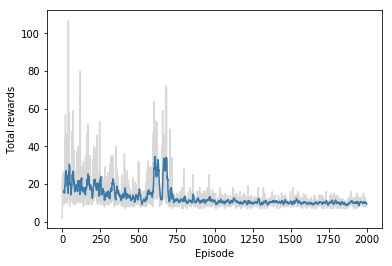

In [24]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Q losses')

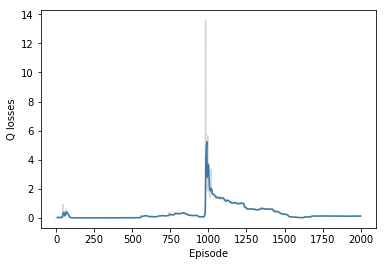

In [25]:
eps, arr = np.array(q_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Q losses')

Text(0,0.5,'G losses')

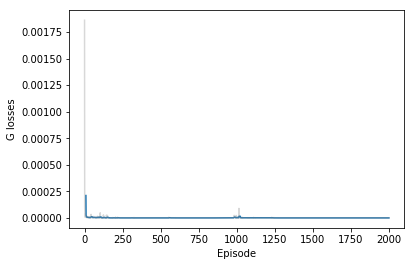

In [26]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'D losses')

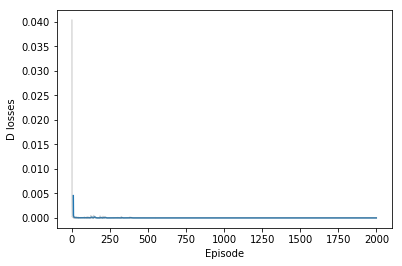

In [27]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

## Testing

Let's checkout how our trained agent plays the game.

In [43]:
test_episodes = 1
test_max_steps = 20000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000

# # # Create the env after closing it.
# # env = gym.make('CartPole-v0')
# # env = gym.make('Acrobot-v1')
# env.reset()

with tf.Session() as sess:
    
    # Restore/load the trained model 
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # iterations
    for ep in range(test_episodes):
        
        # number of env/rob steps
        t = 0
        while t < test_max_steps:
            
            # Rendering the env graphics
            env.render()
            
            # Get action from the model
            feed_dict = {model.prev_actions: np.array([prev_action]), 
                         model.states: state.reshape((1, *state.shape))}
            actions_logits = sess.run(model.actions_logits, feed_dict)
            action = np.argmax(actions_logits)
            
            # Take action, get new state and reward
            next_state, _, done, _ = env.step(action)
            
            # The task is done or not;
            if done:
                t = test_max_steps
                env.reset()
                
                # Take one random step to get the pole and cart moving
                prev_action = env.action_space.sample()
                state, reward, done, _ = env.step(prev_action)
            else:
                state = next_state
                t += 1

INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt


In [45]:
# Closing the env
# WARNING: If you close, you can NOT restart again!!!!!!
env.close()

## Extending this to Deep Convolutional QAN

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.